Imports

In [1]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Constants and Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Use the Negative Log Likelihood Loss function on the outputs after log_softmax activation
lossFn = nn.NLLLoss()

In [4]:
args={}
kwargs={}

args['input_size'] = 784  #Number of features in the input image(of size 28x28)
args['depth'] = 4  #Number of layers in the neural network
args['width']=64  #Number of neurons in each hidden layer
args['batch_size']=32  #Number of samples in each batch
args['epochs']=30  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=5e-5  #Learning rate is how fast it will decend. 
args['eps']=1e-7  #Epsilon value for Adam

args['cuda']=False  #Use GPU or not

In [6]:
eps, beta = 0.1, 4

Load the dataset

In [5]:
#load the train data and validation data, and normalize it

mnist_transforms=[
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
     ]

train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

validation_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Train and validation functions

In [7]:
def train(model, epoch, train_loader, lossFn, optimizer):
  model.train()
  loss = 0
  net_loss = 0
  correct = 0
  
  for batch_idx, (data, target) in enumerate(train_loader):
      if args['cuda']:
          data, target = data.cuda(), target.cuda()
      
      #Reshape the input image to 1D vector
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)

      #This will zero out the gradients for this batch. 
      optimizer.zero_grad()

      #Run the model on the train data
      output = model(data)
      
      # Calculate the loss
      loss = lossFn(output, target)
      net_loss += loss.data

      #dloss/dx for every Variable 
      loss.backward()

      #to do a one-step update on our parameter.
      optimizer.step()

      pred = output.data.max(1, keepdim=True)[1]  #get the index of the max log-probability which is the predicted class

      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

      
  #Print out the loss
  print('Train Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss/len(train_loader.dataset), correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))

def validate(model, validation_loader, lossFn):

  model.eval()
  validation_loss = 0
  correct = 0

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data, target in validation_loader:
      if args['cuda']:
          data, target = data.cuda(), target.cuda()

      #Reshape the input image to 1D vector
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)

      #Run the model on the validation data and get its predictions
      output = model(data)

      #Calculate the loss
      validation_loss += lossFn(output, target).data.item()  #sum up batch loss

      pred = output.data.max(1, keepdim=True)[1]  #get the index of the max log-probability which is the predicted class

      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()  #find the number of correct predictions

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      validation_loss/len(validation_loader.dataset), correct, len(validation_loader.dataset),
      100. * correct / len(validation_loader.dataset)))

DLGN 

In [8]:
#Class implementing the soft ReLU activation function
class SoftGate(nn.Module):
    def __init__(self, **kwargs):
        super(SoftGate, self).__init__()

    def build(self, input_shape):
        super(SoftGate, self).build(input_shape)  

    def forward(self, x):
        activation = (1 + eps)*F.sigmoid(beta*x)
        return activation

    def compute_output_shape(self, input_shape):
        return input_shape


In [33]:
class Galu(nn.Module):
  def __init__(self, depth, width, input_size):

    super(Galu, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'NPF_L1', nn.Linear(input_size, width))  #NPF network's layer 1

    setattr(self,'NPV_L1', nn.Linear(input_size, width))

    for i in range(depth - 2):
      setattr(self,'NPF_L{}'.format(i+2), nn.Linear(width, width))

      setattr(self,'NPV_L{}'.format(i+2), nn.Linear(width, width))

    self.outputs = nn.Linear(width, 10)
      
  def forward(self, x):
    Zf = getattr(self,'NPF_L1')(x)  #Linear activations(So Qf = Zf) of layer 1 of NPF network
    G = SoftGate()(Zf)  #Gating values

    Qv = getattr(self,'NPV_L1')(x)  #Pre-activations of layer 1 of NPV network
    Zv = torch.mul(G, Qv)  #Gating value(from NPF) times Pre-Activations of layer 1 of NPV network is the Activations for layer 1 of NPV network

    # Repeat the above computations for all the hidden layers
    for i in range(self.depth-2):
      Zf = getattr(self,'NPF_L{}'.format(i+2))(Zf)
      G = SoftGate()(Zf)

      Qv = getattr(self,'NPV_L{}'.format(i+2))(Zv)
      Zv = torch.mul(G, Qv)

    return F.log_softmax(self.outputs(Zv))

In [35]:
decoupled_model = Galu(args['depth'], args['width'], args['input_size'])
print(decoupled_model)
print()

if args['cuda']:
    decoupled_model.cuda()

optimizer = optim.Adam(decoupled_model.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(decoupled_model, epoch, train_loader, lossFn, optimizer)
    validate(decoupled_model, validation_loader, lossFn)

Galu(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=True)
  (outputs): Linear(in_features=64, out_features=10, bias=True)
)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 	Loss: 0.016587, Accuracy: 51162/60000 (85%)

Validation set: Average loss: 0.0077, Accuracy: 9298/10000 (93%)

Train Epoch: 2 	Loss: 0.006808, Accuracy: 56075/60000 (93%)

Validation set: Average loss: 0.0060, Accuracy: 9399/10000 (94%)

Train Epoch: 3 	Loss: 0.005254, Accuracy: 56983/60000 (95%)

Validation set: Average loss: 0.0050, Accuracy: 9499/10000 (95%)

Train Epoch: 4 	Loss: 0.004342, Accuracy: 57495/60000 (96%)

Validation set: Average loss: 0.0044, Accuracy: 9565/10000 (96%)

Train Epoch: 5 	Loss: 0.003686, Accuracy: 57852/60000 (96%)

Validation set: Average loss: 0.0039, Accuracy: 9610/10000 (96%)

Train Epoch: 6 	Loss: 0.003191, Accuracy: 58155/60000 (97%)

Validation set: Average loss: 0.0040, Accuracy: 9582/10000 (96%)

Train Epoch: 7 	Loss: 0.002819, Accuracy: 58375/60000 (97%)

Validation set: Average loss: 0.0037, Accuracy: 9615/10000 (96%)

Train Epoch: 8 	Loss: 0.002512, Accuracy: 58529/60000 (98%)

Validation set: Average loss: 0.0032, Accuracy: 96

DLGN with constant input to NPV and no bias

In [ ]:
class GaluConstantNPVNoBias(nn.Module):
  def __init__(self, depth, width, input_size):

    super(GaluConstantNPVNoBias, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'NPF_L1', nn.Linear(input_size, width, bias=False))  #NPF network's layer 1

    setattr(self,'NPV_L1', nn.Linear(input_size, width, bias=False))

    for i in range(depth - 2):
      setattr(self,'NPF_L{}'.format(i+2), nn.Linear(width, width, bias=False))

      setattr(self,'NPV_L{}'.format(i+2), nn.Linear(width, width, bias=False))

    setattr(self,'NPV_L{}'.format(depth), nn.Linear(width, 10, bias=False))
      
  def forward(self, x):
    Zf = getattr(self,'NPF_L1')(x)  #Linear activations(So Qf = Zf) of layer 1 of NPF network
    G = SoftGate()(Zf)  #Gating values

    Qv = getattr(self,'NPV_L1')(torch.Tensor(np.ones(x.shape)))  #Pre-activations of layer 1 of NPV network with constant input
    Zv = torch.mul(G, Qv)  #Gating value(from NPF) times Pre-Activations of layer 1 of NPV network is the Activations for layer 1 of NPV network

    # Repeat the above computations for all the hidden layers
    for i in range(self.depth-2):
      Zf = getattr(self,'NPF_L{}'.format(i+2))(Zf)
      G = SoftGate()(Zf)

      Qv = getattr(self,'NPV_L{}'.format(i+2))(Zv)
      Zv = torch.mul(G, Qv)

      Q_op = getattr(self,'NPV_L{}'.format(self.depth))(Zv)

    return [Q_op, F.log_softmax(Q_op)]
    # return F.log_softmax(getattr(self,'NPV_L{}'.format(self.depth))(Zv))

In [ ]:
decoupled_const_NPV_no_bias_model = GaluConstantNPVNoBias(args['depth'], args['width'], args['input_size'])
print(decoupled_const_NPV_no_bias_model)
print()

GaluConstantNPVNoBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)



Get weights of Network before training

In [ ]:
weight = decoupled_const_NPV_no_bias_model.state_dict()['NPV_L1.weight']
print(weight)
print(weight.shape)

tensor([[-0.0159,  0.0282,  0.0022,  ..., -0.0254, -0.0192,  0.0108],
        [ 0.0187, -0.0258,  0.0125,  ..., -0.0189, -0.0138,  0.0188],
        [ 0.0302, -0.0240, -0.0268,  ...,  0.0319, -0.0142, -0.0079],
        ...,
        [-0.0310, -0.0288,  0.0082,  ...,  0.0094, -0.0115, -0.0208],
        [-0.0161, -0.0196, -0.0317,  ...,  0.0222,  0.0248,  0.0209],
        [ 0.0046,  0.0072, -0.0334,  ..., -0.0112, -0.0229, -0.0267]])
torch.Size([64, 784])


Function to get the weights of NPV network

In [20]:
def get_NPV_weights(model):
  weights = []

  for i in range(args['depth']):
    layer_weight = model.state_dict()['NPV_L{}.weight'.format(i+1)]
    weights.append(layer_weight)

  return weights

In [ ]:
NPV_weights_before_training = get_NPV_weights(decoupled_const_NPV_no_bias_model)
NPV_weights_before_training[:2]

[tensor([[-0.0159,  0.0282,  0.0022,  ..., -0.0254, -0.0192,  0.0108],
         [ 0.0187, -0.0258,  0.0125,  ..., -0.0189, -0.0138,  0.0188],
         [ 0.0302, -0.0240, -0.0268,  ...,  0.0319, -0.0142, -0.0079],
         ...,
         [-0.0310, -0.0288,  0.0082,  ...,  0.0094, -0.0115, -0.0208],
         [-0.0161, -0.0196, -0.0317,  ...,  0.0222,  0.0248,  0.0209],
         [ 0.0046,  0.0072, -0.0334,  ..., -0.0112, -0.0229, -0.0267]]),
 tensor([[ 0.0388,  0.1113,  0.0546,  ...,  0.0123,  0.1142, -0.0621],
         [-0.0107,  0.0437, -0.0243,  ..., -0.0939, -0.0689, -0.0699],
         [-0.0750,  0.1064, -0.0758,  ..., -0.0112,  0.1205,  0.0715],
         ...,
         [ 0.0863, -0.0198,  0.0384,  ...,  0.0053, -0.0472, -0.0884],
         [ 0.0537, -0.0944, -0.0326,  ..., -0.1211,  0.0278, -0.0030],
         [-0.0034,  0.0088, -0.0606,  ..., -0.0594,  0.0915,  0.0690]])]

In [ ]:
print(len(NPV_weights_before_training))
print(NPV_weights_before_training[0].shape)

4
torch.Size([64, 784])


In [ ]:
NPV_weights_before_training[0][30].shape

torch.Size([784])

Function to get the effective weights of NPF network

In [11]:
def get_NPF_effective_weights(model, bias=False):

  effective_weights = []
  effective_biases = []
  
  for i in range(args['depth']-1):
      curr_weight = model.state_dict()['NPF_L{}.weight'.format(i+1)]
      if i==0:
          effective_weights.append(curr_weight)
          if bias:
            curr_bias = model.state_dict()['NPF_L{}.bias'.format(i+1)]
            effective_biases.append(curr_bias)
      else:
          effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
          if bias:
            curr_bias = model.state_dict()['NPF_L{}.bias'.format(i+1)]
            effective_biases.append(torch.matmul(curr_weight, effective_biases[-1])+curr_bias)

  if bias:
    return effective_weights, effective_biases
    
  return effective_weights
  # effective_weights is a list of size depth-1

In [ ]:
NPF_effective_weights_before_training = get_NPF_effective_weights(decoupled_const_NPV_no_bias_model)
NPF_effective_weights_before_training[:2]

[tensor([[ 4.2517e-03,  7.2379e-03, -2.9836e-02,  ...,  2.0600e-02,
           1.1425e-02, -2.5795e-02],
         [-4.2214e-03,  9.8267e-03, -2.8774e-03,  ...,  9.8549e-03,
          -1.4074e-02,  3.2295e-02],
         [-1.8057e-02, -3.3790e-02,  1.5556e-02,  ..., -1.2957e-02,
          -1.3862e-05, -2.6325e-02],
         ...,
         [-3.0461e-02, -9.2177e-03, -1.8771e-02,  ..., -1.0021e-02,
          -2.2083e-02, -1.7937e-02],
         [ 1.6651e-03,  7.2596e-03, -2.1505e-02,  ..., -1.4452e-02,
          -2.0289e-02,  3.3638e-02],
         [-3.4552e-02, -7.4834e-03, -1.9694e-02,  ..., -2.7596e-02,
          -2.0333e-02,  1.9802e-02]]),
 tensor([[-0.0005, -0.0117,  0.0023,  ..., -0.0030,  0.0052, -0.0041],
         [-0.0029,  0.0053,  0.0046,  ...,  0.0063,  0.0183, -0.0060],
         [ 0.0120, -0.0059, -0.0016,  ...,  0.0054,  0.0209,  0.0115],
         ...,
         [ 0.0072,  0.0219,  0.0102,  ...,  0.0062,  0.0175, -0.0012],
         [ 0.0074, -0.0013,  0.0052,  ...,  0.0146,  0.0

In [ ]:
if args['cuda']:
    decoupled_const_NPV_no_bias_model.cuda()

optimizer = optim.Adam(decoupled_const_NPV_no_bias_model.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(decoupled_const_NPV_no_bias_model, epoch, train_loader, lossFn, optimizer)
    validate(decoupled_const_NPV_no_bias_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 	Loss: 0.014416, Accuracy: 51819/60000 (86%)

Validation set: Average loss: 0.0071, Accuracy: 9293/10000 (93%)

Train Epoch: 2 	Loss: 0.006432, Accuracy: 56283/60000 (94%)

Validation set: Average loss: 0.0056, Accuracy: 9455/10000 (95%)

Train Epoch: 3 	Loss: 0.004950, Accuracy: 57115/60000 (95%)

Validation set: Average loss: 0.0045, Accuracy: 9539/10000 (95%)

Train Epoch: 4 	Loss: 0.004063, Accuracy: 57625/60000 (96%)

Validation set: Average loss: 0.0041, Accuracy: 9592/10000 (96%)

Train Epoch: 5 	Loss: 0.003446, Accuracy: 58008/60000 (97%)

Validation set: Average loss: 0.0038, Accuracy: 9634/10000 (96%)

Train Epoch: 6 	Loss: 0.002977, Accuracy: 58244/60000 (97%)

Validation set: Average loss: 0.0036, Accuracy: 9656/10000 (97%)

Train Epoch: 7 	Loss: 0.002616, Accuracy: 58446/60000 (97%)

Validation set: Average loss: 0.0035, Accuracy: 9660/10000 (97%)

Train Epoch: 8 	Loss: 0.002289, Accuracy: 58641/60000 (98%)

Validation set: Average loss: 0.0034, Accuracy: 96

In [ ]:
list(decoupled_const_NPV_no_bias_model.state_dict().items())[:2]

[('NPF_L1.weight',
  tensor([[-0.0002,  0.0028, -0.0343,  ...,  0.0161,  0.0070, -0.0303],
          [-0.0095,  0.0046, -0.0081,  ...,  0.0046, -0.0193,  0.0271],
          [-0.0196, -0.0353,  0.0140,  ..., -0.0145, -0.0016, -0.0279],
          ...,
          [-0.0277, -0.0065, -0.0160,  ..., -0.0073, -0.0193, -0.0152],
          [ 0.0085,  0.0141, -0.0146,  ..., -0.0076, -0.0134,  0.0405],
          [-0.0400, -0.0129, -0.0251,  ..., -0.0330, -0.0258,  0.0144]])),
 ('NPV_L1.weight',
  tensor([[-0.0715, -0.0274, -0.0534,  ..., -0.0810, -0.0747, -0.0447],
          [-0.0467, -0.0913, -0.0529,  ..., -0.0844, -0.0793, -0.0467],
          [-0.0132, -0.0674, -0.0701,  ..., -0.0115, -0.0576, -0.0512],
          ...,
          [-0.0945, -0.0922, -0.0552,  ..., -0.0541, -0.0750, -0.0843],
          [-0.0581, -0.0616, -0.0737,  ..., -0.0198, -0.0172, -0.0211],
          [ 0.0578,  0.0604,  0.0198,  ...,  0.0420,  0.0303,  0.0265]]))]

Store weights of all layers

In [ ]:
torch.save(decoupled_const_NPV_no_bias_model.state_dict(), './Constant NPV Model with no bias')

Load the model

In [ ]:
decoupled_const_NPV_no_bias_model = GaluConstantNPVNoBias(args['depth'], args['width'], args['input_size'])
decoupled_const_NPV_no_bias_model.load_state_dict(torch.load('./Constant NPV Model with no bias'))
decoupled_const_NPV_no_bias_model.eval()

GaluConstantNPVNoBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)

Calculate importance value for all paths

In [ ]:
NPV_weights = get_NPV_weights(decoupled_const_NPV_no_bias_model)

In [ ]:
nodes_considered = [0]*args['depth']
print(nodes_considered)
print(len(nodes_considered))

[0, 0, 0, 0]
4


In [39]:
widths = [args['width']]*3
widths.append(10)
print(widths)
print(len(widths))

[64, 64, 64, 10]
4


In [ ]:
value = np.ones((args['input_size']))
prev_nodes = range(args['input_size'])

for layer,node in enumerate([0,0,0,0]):
  print("Layer:",layer+1)
  print("Node:", node+1)
  print("Weight for node:", NPV_weights[layer][node][prev_nodes].shape)
  print("Value shape initial:", value.shape)
  value = np.array(np.dot(NPV_weights[layer][node][prev_nodes], value))
  print("Final value Result: ", value)
  print()
  prev_nodes = node

Layer: 1
Node: 1
Weight for node: torch.Size([784])
Value shape initial: (784,)
Final value Result:  -44.15606672875583

Layer: 2
Node: 1
Weight for node: torch.Size([])
Value shape initial: ()
Final value Result:  -2.8037527413488332

Layer: 3
Node: 1
Weight for node: torch.Size([])
Value shape initial: ()
Final value Result:  0.36432365086183555

Layer: 4
Node: 1
Weight for node: torch.Size([])
Value shape initial: ()
Final value Result:  0.04012674924503853



In [12]:
def get_path_value(weights, widths):
  i = args['depth']-1
  nodes_considered = [0]*args['depth']
  paths = dict()

  while(i >= 0):
    path = tuple(nodes_considered)  # this is the current path

    importance_value = np.ones((784))  # initialize to constant(input to NPV network is all 1s)
    prev_nodes = range(args['input_size'])  # nodes to be considered in the previous layer

   # loop to compute importance value of current path
    for layer,node in enumerate(nodes_considered):
      importance_value = np.dot(weights[layer][node][prev_nodes], importance_value)
      prev_nodes = node

    # store the importance value and the path
    paths[path] = importance_value

    # consider the next lexicographic permutation of nodes(the next path)
    while(i >= 0 and nodes_considered[i] == widths[i]-1):
      nodes_considered[i] = 0
      i -= 1
    
    if i>=0:
      nodes_considered[i] += 1
      i = args['depth']-1

    # print(i, nodes_considered)

  return paths

In [ ]:
paths = get_path_value(NPV_weights, widths)

In [ ]:
print(len(paths))
print()
print(list(paths.items())[-10:])

2621440

[((63, 63, 63, 0), -0.001034995397436852), ((63, 63, 63, 1), -0.0010960640276178055), ((63, 63, 63, 2), -0.0005497970297301186), ((63, 63, 63, 3), -0.0004014159432239208), ((63, 63, 63, 4), 9.269573717931606e-05), ((63, 63, 63, 5), -0.0008724423650636745), ((63, 63, 63, 6), -0.000310259120982935), ((63, 63, 63, 7), -0.0002501156398380619), ((63, 63, 63, 8), 0.0020071650572893386), ((63, 63, 63, 9), -0.0009370987474632702)]


Sort the paths by absolute value of importance

In [ ]:
keys = sorted(paths, key = lambda dict_key: abs(paths[dict_key]), reverse=True)
for k in keys[:100]:
  print(k, paths[k])

(39, 34, 44, 6) 0.3771533084190457
(20, 54, 47, 6) 0.36384292404656643
(45, 25, 31, 9) 0.3596158788615327
(39, 42, 31, 9) -0.3420900201758857
(20, 54, 15, 1) -0.33743093005183217
(20, 54, 47, 0) 0.3359198213689152
(20, 54, 15, 6) 0.333650003276479
(39, 34, 19, 0) 0.3331732566243804
(42, 23, 7, 7) 0.3290486109143496
(45, 50, 15, 1) 0.3289366035749899
(39, 10, 7, 7) 0.3253248094818198
(45, 50, 15, 6) -0.32525085606020404
(39, 42, 44, 6) -0.3216807523894958
(39, 14, 7, 7) -0.32032551558615663
(43, 47, 44, 6) 0.3196427559132174
(43, 47, 0, 2) -0.3174596950796311
(20, 54, 47, 2) 0.3168199803074163
(39, 34, 0, 2) -0.31626597639689435
(42, 23, 44, 6) 0.31581386884223633
(20, 54, 15, 5) -0.3150824057375313
(20, 54, 15, 0) 0.30742869560476394
(39, 34, 7, 7) 0.30740089958607014
(45, 50, 15, 5) 0.30715067043089433
(43, 47, 7, 7) 0.3047749489327057
(45, 50, 15, 0) -0.29968963117336905
(20, 54, 62, 7) 0.29663616232269485
(47, 23, 7, 7) 0.29633571938807296
(45, 25, 45, 8) -0.29477339777026607
(20, 5

In [ ]:
for i in range(10):
  print('(39,34,44,{})'.format(i), paths[(39,34,44,i)])

(39,34,44,0) 0.24264665222637963
(39,34,44,1) -0.1981431015185324
(39,34,44,2) -0.23959027868087027
(39,34,44,3) 0.02134767995168972
(39,34,44,4) 0.023663505623773572
(39,34,44,5) -0.00472209375041904
(39,34,44,6) 0.3771533084190457
(39,34,44,7) 0.13312125687703177
(39,34,44,8) 0.04352870800279625
(39,34,44,9) -0.28193787606088005


Method 1: Visualize the half-spaces corresponding to nodes in most important paths

In [ ]:
NPF_effective_weights = get_NPF_effective_weights(decoupled_const_NPV_no_bias_model)

In [ ]:
print("Num layers:", len(NPF_effective_weights))
print("Num nodes in layer 2:", len(NPF_effective_weights[1]))
print("Dimension of effective weight of node 1 in layer 2:",len(NPF_effective_weights[1][0]))

Num layers: 3
Num nodes in layer 2: 64
Dimension of effective weight of node 1 in layer 2: 784


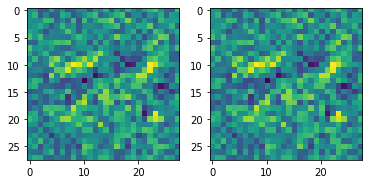

In [ ]:
img = np.array(NPF_effective_weights[0][0])
img.shape = (28,28)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

In [47]:
def visualize_effective_weights(paths, weights_before, weights_after, biases_before=None, biases_after=None):

  for path in paths:

    print("Path:", path)
    print()

    for layer, node in enumerate(path[:-1]):
      print("Layer:",layer+1)
      print("Node:",node+1)

      img1 = np.array(weights_before[layer][node])
      img2 = np.array(weights_after[layer][node])

      if biases_before:
        img1 /= np.abs(biases_before[layer][node].item())
        
      if biases_after:
        img2 /= np.abs(biases_after[layer][node].item())

      img1.shape = (28,28)
      img2.shape = (28,28)

      fig = plt.figure()
      ax1 = fig.add_subplot(1,2,1)
      ax1.imshow(img1)

      ax2 = fig.add_subplot(1,2,2)
      ax2.imshow(img2)

      title1 = "Initial - Layer:" + str(layer) + " Node:" + str(node)
      title2 = "Final - Layer:" + str(layer) + " Node:" + str(node)
      if biases_before:
        if biases_before[layer][node] > 0:
          title1 = title1 + " \n and bias is positive"
          title2 = title2 + " \n and bias is positive"
        else:
          title1 = title1 + " \n and bias is negative"
          title2 = title2 + " \n and bias is negative"

      ax1.title.set_text(title1)
      ax2.title.set_text(title2)
      # fig.colorbar(img1, ax1)
      # fig.colorbar(img2, ax2)

    print()
    print()

In [ ]:
keys[0][:-1]

(39, 34, 44)

Path: (39, 34, 44, 6)

Layer: 1
Node: 40
Layer: 2
Node: 35
Layer: 3
Node: 45




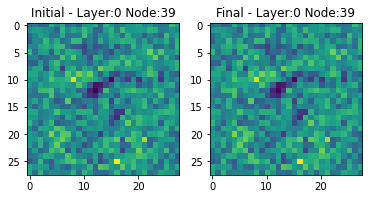

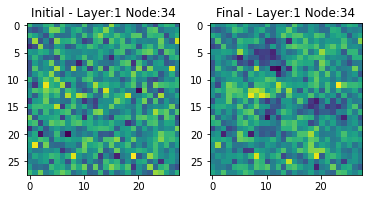

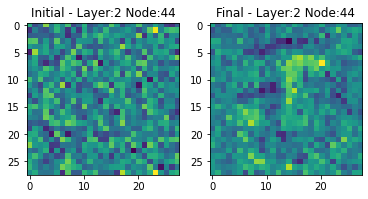

In [ ]:
visualize_effective_weights([keys[0]], NPF_effective_weights_before_training, NPF_effective_weights)

The above visualization does not give us much information about the nodes(whether or not they learn any useful features)

Method 2: Visualize output for each node using the MNIST Data

In [55]:
#load the train data and validation data, and normalize it

# Transform to normalized Tensors 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

dataset = datasets.MNIST('./MNIST/', transform=transform, download=True)

data_loader = DataLoader(dataset, batch_size=len(dataset))

X = next(iter(data_loader))[0].numpy()
Y = next(iter(data_loader))[1].numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [56]:
print(X.shape)
print(Y.shape)

(60000, 784)
(60000,)


In [57]:
print(Y[:100])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]


In [58]:
print(X[1])
print()
print(X[4])

[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0

Pre-activations for class sample corresponding to most important path

In [59]:
i, = np.where(Y==6)
i[0]

13

In [60]:
X[i[0]].shape

(784,)

In [ ]:
Q, Z = decoupled_const_NPV_no_bias_model(torch.tensor(X[i[0]]))
print(Q)

tensor([ -4.0705,  -9.7212,  -0.6911, -12.5293,  -0.8336,   3.6428,  23.8347,
        -12.8524,  -0.4079, -13.2665], grad_fn=<SqueezeBackward3>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Seggregate data by class

In [61]:
idx = np.argsort(Y)
X_sorted = X[idx]
Y_sorted = Y[idx]

In [62]:
print(X_sorted.shape)
print(Y_sorted.shape)

(60000, 784)
(60000,)


In [63]:
print(Y_sorted[:100])
print()
print(Y_sorted[-100:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [64]:
print(X_sorted[0])
print()
print(X_sorted[4])

[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0

In [65]:
def get_class_sizes(Y):
  class_sizes = []
  for i in range(10):
    class_sizes.append(np.count_nonzero(Y==i))

  return class_sizes

In [66]:
class_sizes = get_class_sizes(Y_sorted)
class_sizes

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [67]:
np.sum(class_sizes)

60000

In [68]:
X_sorted.shape[0]

60000

In [52]:
def get_output_for_given_path(path, data, class_sizes, intervals, weights, biases=None, averaging=True): 
  
  outputs = []
  # class_sizes.append(data.shape[0])

  for layer, node in enumerate(path[:-1]):

    if biases:
      output = np.dot(weights[layer][node], data.T) + biases[layer][node].item()
    else:
      output = np.dot(weights[layer][node], data.T)

    output = SoftGate()(torch.tensor(output))    
    # output = F.log_softmax((torch.tensor(output)))
    
    if averaging:
      Y = []
      start = 0
      for i in range(len(intervals)):
        Y.append(np.average(output[start:start+class_sizes[i]]))
        start += class_sizes[i]

      print(Y)

    else:
      Y = output

    outputs.append((node,Y))


    plt.plot(intervals,Y[:len(intervals)],label="Node " + str(node) +" in layer " + str(layer))
    plt.legend()
    plt.show()
    print()

  return outputs

In [71]:
def visualize_halfspace_intersections(outputs, X_axis):

  for layer, (node,Y_axis) in enumerate(outputs):
    plt.plot(X_axis, Y_axis[:len(X_axis)], label="Node " + str(node) + " in layer: " + str(layer))
  plt.legend()
  plt.show()

In [72]:
print(Y_sorted[5900:5924])
print(Y[5900:5924])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[2 9 2 1 5 0 7 2 2 2 6 3 7 6 2 1 8 8 9 3 6 0 3 3]


In [ ]:
keys[0]

(39, 34, 44, 6)

Visualize average of outputs across each class for the nodes in the most important path

Before training

[0.5853508, 0.08899411, 0.19114965, 0.119597785, 0.20542628, 0.29332837, 0.1587099, 0.37098533, 0.10774539, 0.33397618]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


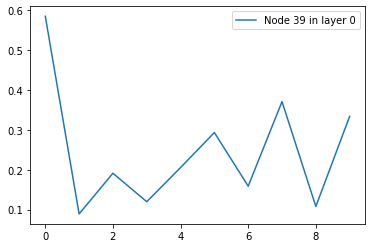


[0.41796744, 0.7511859, 0.43014345, 0.46462092, 0.51083994, 0.42548725, 0.4936811, 0.61540544, 0.42998388, 0.4411646]


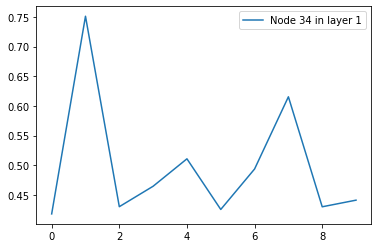


[0.5298015, 0.59399235, 0.49723595, 0.5649278, 0.54113114, 0.5022079, 0.41554558, 0.6258065, 0.4711128, 0.51995844]


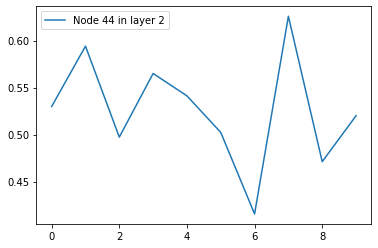

In [ ]:
outputs = get_output_for_given_path(keys[0], X_sorted, class_sizes, range(10), NPF_effective_weights_before_training)

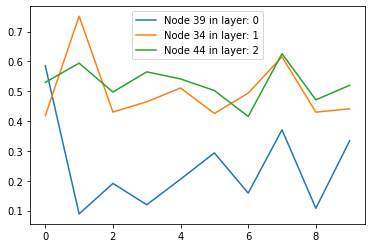

In [ ]:
visualize_halfspace_intersections(outputs, range(10))


After training

[0.5853508, 0.08899411, 0.19114965, 0.119597785, 0.20542628, 0.29332837, 0.1587099, 0.37098533, 0.10774539, 0.33397618]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


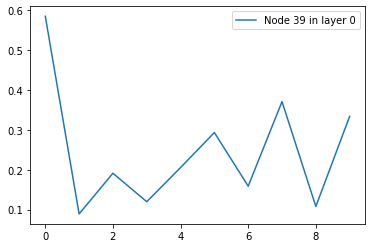


[0.79920155, 0.9731589, 0.30382797, 0.44242597, 0.81555706, 0.83183354, 0.31024876, 0.7473767, 0.62363607, 0.90321577]


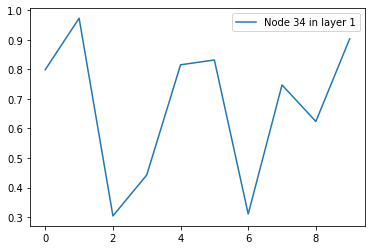


[0.85778636, 1.0937489, 0.914123, 0.9415247, 0.8383823, 0.84682167, 0.4840396, 1.0201391, 0.9588161, 1.0640664]


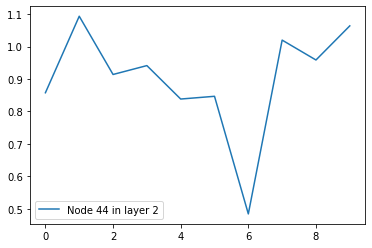

In [ ]:
outputs = get_output_for_given_path(keys[0], X_sorted, class_sizes, range(10), NPF_effective_weights)

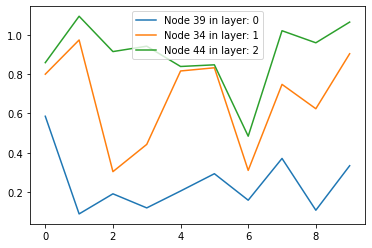

In [ ]:
visualize_halfspace_intersections(outputs, range(10))

We see that there is not much change in the output for first layer

Visualize half-spaces of nodes in second most important path

[1.0027484, 0.0612662, 0.49982867, 0.09097394, 0.48788968, 0.34140855, 0.12760213, 0.33811927, 0.28166422, 0.18823595]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


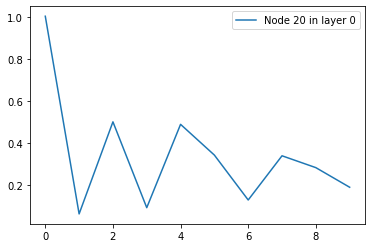


[1.0619484, 0.02900625, 0.6788205, 0.8676023, 0.31137508, 0.8203883, 0.71920633, 0.29752976, 0.31020218, 0.3438991]


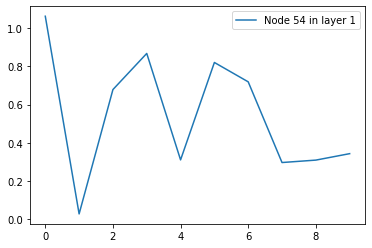


[0.24250966, 1.0421739, 0.6173484, 0.9004659, 0.87363786, 0.92414725, 0.86590815, 1.0741736, 0.80560696, 1.0038478]


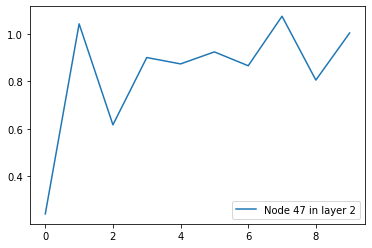

In [ ]:
outputs = get_output_for_given_path(keys[1], X_sorted, class_sizes, range(10), NPF_effective_weights)

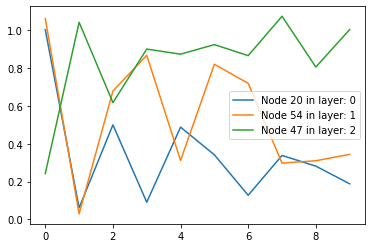

In [ ]:
visualize_halfspace_intersections(outputs, range(10))

I also tried to visualize the intersection on individual datapoints without averaging

Visualizing the datapoints using the class-wise sorted data

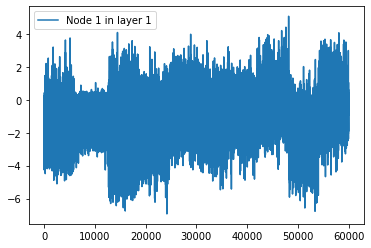

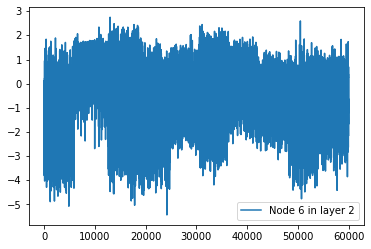

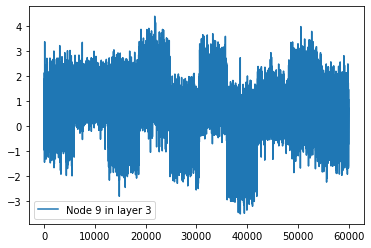

[(0, array([-1.4513332 , -2.1838121 , -4.256386  , ...,  0.1658192 ,
         -0.3385327 ,  0.42677912], dtype=float32)),
 (5, array([-3.556649  , -2.4545336 , -1.5197921 , ..., -0.7598788 ,
          0.69653165,  0.27781612], dtype=float32)),
 (8, array([ 1.756293  , -0.34719744, -0.58843917, ..., -0.44997054,
          1.4597063 ,  1.0396764 ], dtype=float32))]

In [ ]:
get_output_for_given_path(keys[0], X_sorted, class_sizes, range(X.shape[0]), NPF_effective_weights, None, False)

Visualizing using the raw data(without sorting by class)

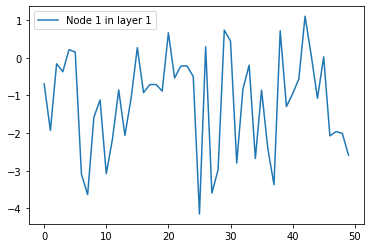

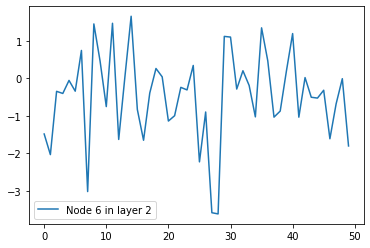

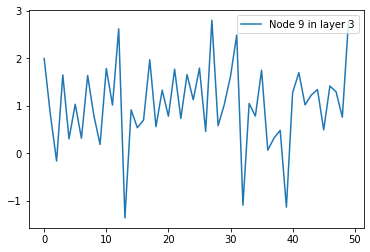

In [ ]:
outputs = get_output_for_given_path(keys[0], X, class_sizes, range(50), NPF_effective_weights, None, False)

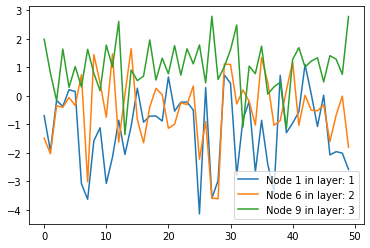

In [ ]:
visualize_halfspace_intersections(outputs, range(50))

Range of values a given node produces for class 0 data

In [ ]:
print("Max pre-activation for class 0 in layer 1 node "+ str(outputs[0][0]+1) +" is " + str(np.max(outputs[0][1][:class_sizes[0]])))
print("Min pre-activation for class 0 in layer 1 node "+ str(outputs[0][0]+1) +" is " + str(np.min(outputs[0][1][:class_sizes[0]])))

Max pre-activation for class 0 in layer 1 node 1 is 3.6287248
Min pre-activation for class 0 in layer 1 node 1 is -6.220417


The average value across nodes for class 0

In [ ]:
print(np.average(outputs[0][1][:class_sizes[0]]))
print(np.average(outputs[1][1][:class_sizes[0]]))
print(np.average(outputs[2][1][:class_sizes[0]]))

-1.2131226
-0.69899577
0.6858039


DLGN Constant Input to NPV(with bias only for NPF Network)

In [22]:
class GaluConstantNPVWithNPFBias(nn.Module):
  def __init__(self, depth, width, input_size):

    super(GaluConstantNPVWithNPFBias, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'NPF_L1', nn.Linear(input_size, width))  #NPF network's layer 1

    setattr(self,'NPV_L1', nn.Linear(input_size, width, bias=False))

    for i in range(depth - 2):
      setattr(self,'NPF_L{}'.format(i+2), nn.Linear(width, width))

      setattr(self,'NPV_L{}'.format(i+2), nn.Linear(width, width, bias=False))

    setattr(self,'NPV_L{}'.format(depth), nn.Linear(width, 10, bias=False))
      
  def forward(self, x):
    Zf = getattr(self,'NPF_L1')(x)  #Linear activations(So Qf = Zf) of layer 1 of NPF network
    G = SoftGate()(Zf)  #Gating values

    Qv = getattr(self,'NPV_L1')(torch.Tensor(np.ones(x.shape)))  #Pre-activations of layer 1 of NPV network with constant input
    Zv = torch.mul(G, Qv)  #Gating value(from NPF) times Pre-Activations of layer 1 of NPV network is the Activations for layer 1 of NPV network

    # Repeat the above computations for all the hidden layers
    for i in range(self.depth-2):
      Zf = getattr(self,'NPF_L{}'.format(i+2))(Zf)
      G = SoftGate()(Zf)

      Qv = getattr(self,'NPV_L{}'.format(i+2))(Zv)
      Zv = torch.mul(G, Qv)

    return F.log_softmax(getattr(self,'NPV_L{}'.format(self.depth))(Zv))

In [23]:
decoupled_const_NPV_model_with_NPF_bias = GaluConstantNPVWithNPFBias(args['depth'], args['width'], args['input_size'])
print(decoupled_const_NPV_model_with_NPF_bias)
print()

GaluConstantNPVWithNPFBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)



In [24]:
NPV_weights_before_training = get_NPV_weights(decoupled_const_NPV_model_with_NPF_bias)
NPV_weights_before_training[:2]

[tensor([[-0.0021, -0.0317,  0.0348,  ...,  0.0159, -0.0248, -0.0255],
         [ 0.0030, -0.0172, -0.0343,  ...,  0.0002,  0.0291,  0.0279],
         [-0.0054, -0.0155,  0.0176,  ...,  0.0253, -0.0254,  0.0142],
         ...,
         [-0.0115,  0.0216,  0.0210,  ..., -0.0148, -0.0354, -0.0257],
         [-0.0303,  0.0008,  0.0354,  ...,  0.0074, -0.0086, -0.0209],
         [-0.0027, -0.0299, -0.0161,  ..., -0.0309,  0.0111,  0.0095]]),
 tensor([[ 0.0563,  0.0937,  0.0358,  ..., -0.0638, -0.1248,  0.0723],
         [ 0.0081, -0.0280, -0.1032,  ...,  0.0050, -0.0597, -0.0092],
         [-0.0419,  0.0004,  0.0708,  ...,  0.0389,  0.0715, -0.0846],
         ...,
         [ 0.0506,  0.0885, -0.0481,  ..., -0.0131,  0.0028,  0.0732],
         [ 0.1114,  0.0454,  0.1164,  ...,  0.1096, -0.0964, -0.0685],
         [ 0.1198, -0.1108,  0.0769,  ...,  0.1092,  0.0395,  0.1008]])]

In [26]:
NPF_effective_weights_before_training, NPF_effective_biases_before_training = get_NPF_effective_weights(decoupled_const_NPV_model_with_NPF_bias, bias=True)
print(NPF_effective_weights_before_training[:2])
print()
print(NPF_effective_biases_before_training[:2])

[tensor([[-0.0349,  0.0266, -0.0265,  ...,  0.0048,  0.0083,  0.0353],
        [-0.0202, -0.0197, -0.0334,  ...,  0.0201,  0.0330,  0.0356],
        [ 0.0077, -0.0314, -0.0209,  ..., -0.0355,  0.0182,  0.0069],
        ...,
        [-0.0285, -0.0151, -0.0176,  ..., -0.0249,  0.0172,  0.0108],
        [ 0.0211,  0.0240, -0.0348,  ...,  0.0335,  0.0289,  0.0141],
        [ 0.0308,  0.0006, -0.0080,  ..., -0.0355, -0.0207, -0.0325]]), tensor([[-0.0178, -0.0006,  0.0095,  ...,  0.0091,  0.0236,  0.0123],
        [ 0.0139,  0.0057,  0.0102,  ..., -0.0142,  0.0127,  0.0071],
        [-0.0114, -0.0059,  0.0053,  ...,  0.0010,  0.0162,  0.0093],
        ...,
        [-0.0013, -0.0093,  0.0087,  ...,  0.0044, -0.0042, -0.0086],
        [-0.0109,  0.0125,  0.0079,  ..., -0.0100,  0.0096,  0.0050],
        [ 0.0072,  0.0082,  0.0081,  ..., -0.0068, -0.0127,  0.0076]])]

[tensor([-0.0076, -0.0099,  0.0319, -0.0135, -0.0016,  0.0286,  0.0197, -0.0066,
         0.0084, -0.0344,  0.0292, -0.0319,  0.

In [31]:
print(NPF_effective_weights_before_training[0].shape)
print(NPF_effective_biases_before_training[0].shape)

torch.Size([64, 784])
torch.Size([64])


In [32]:
if args['cuda']:
    decoupled_const_NPV_model_with_NPF_bias.cuda()

optimizer = optim.Adam(decoupled_const_NPV_model_with_NPF_bias.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(decoupled_const_NPV_model_with_NPF_bias, epoch, train_loader, lossFn, optimizer)
    validate(decoupled_const_NPV_model_with_NPF_bias, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 	Loss: 0.014585, Accuracy: 51990/60000 (87%)

Validation set: Average loss: 0.0074, Accuracy: 9301/10000 (93%)

Train Epoch: 2 	Loss: 0.006653, Accuracy: 56106/60000 (94%)

Validation set: Average loss: 0.0057, Accuracy: 9442/10000 (94%)

Train Epoch: 3 	Loss: 0.005121, Accuracy: 57020/60000 (95%)

Validation set: Average loss: 0.0048, Accuracy: 9532/10000 (95%)

Train Epoch: 4 	Loss: 0.004186, Accuracy: 57573/60000 (96%)

Validation set: Average loss: 0.0044, Accuracy: 9562/10000 (96%)

Train Epoch: 5 	Loss: 0.003545, Accuracy: 57942/60000 (97%)

Validation set: Average loss: 0.0040, Accuracy: 9603/10000 (96%)

Train Epoch: 6 	Loss: 0.003082, Accuracy: 58200/60000 (97%)

Validation set: Average loss: 0.0035, Accuracy: 9654/10000 (97%)

Train Epoch: 7 	Loss: 0.002677, Accuracy: 58386/60000 (97%)

Validation set: Average loss: 0.0034, Accuracy: 9668/10000 (97%)

Train Epoch: 8 	Loss: 0.002374, Accuracy: 58611/60000 (98%)

Validation set: Average loss: 0.0033, Accuracy: 96

In [36]:
for name,params in decoupled_const_NPV_model_with_NPF_bias.named_parameters():
  print(f"{name} \t {params.shape}")

NPF_L1.weight 	 torch.Size([64, 784])
NPF_L1.bias 	 torch.Size([64])
NPV_L1.weight 	 torch.Size([64, 784])
NPF_L2.weight 	 torch.Size([64, 64])
NPF_L2.bias 	 torch.Size([64])
NPV_L2.weight 	 torch.Size([64, 64])
NPF_L3.weight 	 torch.Size([64, 64])
NPF_L3.bias 	 torch.Size([64])
NPV_L3.weight 	 torch.Size([64, 64])
NPV_L4.weight 	 torch.Size([10, 64])


In [37]:
torch.save(decoupled_const_NPV_model_with_NPF_bias.state_dict(), './Constant NPV Model With Bias for NPF')

Load the model

In [ ]:
decoupled_const_NPV_model_with_NPF_bias = GaluConstantNPVWithNPFBias(args['depth'], args['width'], args['input_size'])
decoupled_const_NPV_model_with_NPF_bias.load_state_dict(torch.load('./Constant NPV Model With Bias for NPF'))
decoupled_const_NPV_model_with_NPF_bias.eval()

GaluConstantNPVWithNPFBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)

In [ ]:
weight = decoupled_const_NPV_model_with_NPF_bias.state_dict()['NPV_L1.weight']
print(weight)
print(weight.shape)

tensor([[-0.0539, -0.0230, -0.0645,  ..., -0.0190, -0.0662, -0.0443],
        [ 0.0894,  0.0384,  0.0826,  ...,  0.0503,  0.0894,  0.0497],
        [ 0.0449,  0.0079,  0.0027,  ...,  0.0641,  0.0251,  0.0539],
        ...,
        [-0.0633, -0.0279, -0.0274,  ..., -0.0757, -0.0765, -0.0516],
        [ 0.0396,  0.0715,  0.0628,  ...,  0.0344,  0.0286,  0.0671],
        [-0.0274, -0.0266, -0.0838,  ..., -0.0778, -0.0259, -0.0304]])
torch.Size([64, 784])


In [40]:
NPV_weights = get_NPV_weights(decoupled_const_NPV_model_with_NPF_bias)
paths = get_path_value(NPV_weights, widths)

In [41]:
print(len(paths))
print()
print(list(paths.items())[0:10])
print(list(paths.items())[-10:])

2621440

[((0, 0, 0, 0), -0.004707752512175734), ((0, 0, 0, 1), -0.003771885471504211), ((0, 0, 0, 2), -0.0028776182703567437), ((0, 0, 0, 3), 0.0002701297825862641), ((0, 0, 0, 4), 0.0036234153130725788), ((0, 0, 0, 5), 0.00501620186274285), ((0, 0, 0, 6), 0.0011334908562240346), ((0, 0, 0, 7), 0.0021743293434045626), ((0, 0, 0, 8), 0.004595339266180287), ((0, 0, 0, 9), 0.003878827948350684)]
[((63, 63, 63, 0), -0.007304048508320673), ((63, 63, 63, 1), -0.0038561239316034445), ((63, 63, 63, 2), 0.0029684906383390572), ((63, 63, 63, 3), 0.016082765271923528), ((63, 63, 63, 4), -0.02488678534017546), ((63, 63, 63, 5), -0.0017904705557102753), ((63, 63, 63, 6), -0.027829450117978417), ((63, 63, 63, 7), 0.016844919761739942), ((63, 63, 63, 8), 0.001126816523832561), ((63, 63, 63, 9), -0.012034344185577335)]


In [42]:
keys = sorted(paths, key = lambda dict_key: abs(paths[dict_key]), reverse=True)
for k in keys[:100]:
  print(k, paths[k])

(29, 11, 27, 6) 0.4740839018452431
(9, 11, 27, 6) 0.38710435389315573
(1, 13, 14, 4) 0.3866295070233211
(29, 39, 14, 4) 0.34012307541991904
(30, 44, 38, 0) -0.33205825601594974
(29, 11, 53, 9) -0.32870025293027305
(15, 11, 27, 6) 0.3260690051513056
(29, 11, 47, 4) -0.3242446224034432
(29, 39, 13, 7) -0.3213203733743425
(29, 11, 34, 2) 0.3211671354348767
(29, 11, 47, 9) -0.31959503767892466
(1, 13, 1, 8) -0.3189462923974873
(1, 13, 38, 0) -0.3186302811027583
(29, 39, 38, 0) -0.2968065567378179
(10, 25, 38, 0) 0.29659591964527504
(29, 11, 53, 8) -0.2931074923761979
(29, 22, 58, 0) -0.2896217240324613
(29, 11, 47, 3) -0.2888388375138119
(29, 11, 47, 7) 0.2852366985669843
(1, 13, 14, 2) 0.2819524087277819
(30, 44, 35, 0) 0.2794911005155881
(1, 13, 40, 7) 0.2769696656471777
(62, 58, 36, 2) 0.27690471808526224
(10, 45, 38, 0) 0.2761533808165683
(29, 39, 1, 8) -0.27411370553499104
(29, 2, 27, 6) -0.2723012616903993
(62, 36, 8, 6) 0.27174175837130726
(4, 25, 38, 0) 0.27126269608035736
(30, 44,

In [43]:
NPF_effective_weights, NPF_effective_biases = get_NPF_effective_weights(decoupled_const_NPV_model_with_NPF_bias, bias=True)

In [44]:
print(NPF_effective_biases[0][0])
print(NPF_effective_biases[0][0].item())

tensor(-0.0038)
-0.0038126646541059017


Path: (29, 11, 27, 6)

Layer: 1
Node: 30
Layer: 2
Node: 12
Layer: 3
Node: 28




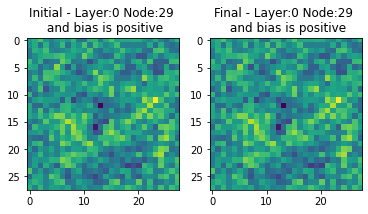

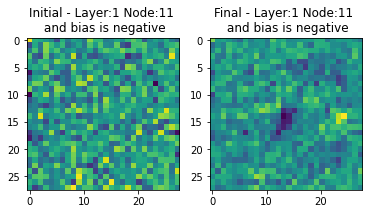

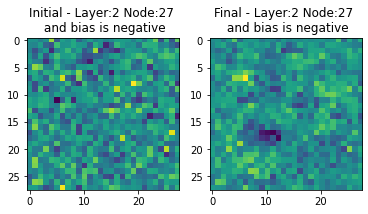

In [48]:
visualize_effective_weights([keys[0]], NPF_effective_weights_before_training, NPF_effective_weights, NPF_effective_biases_before_training, NPF_effective_biases)

Visualize classwise average output of nodes in the most important path

In [50]:
NPF_effective_biases[0][29]

tensor(0.0331)

[1.0446318, 0.17301147, 0.73918563, 0.1303219, 0.6847022, 0.35921898, 0.72739947, 0.65061164, 0.1618376, 0.4153411]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


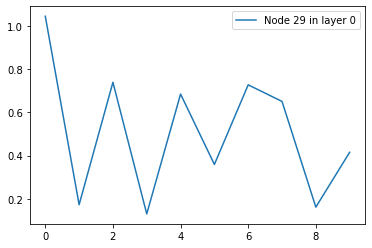


[0.60444933, 0.0024136098, 0.025785357, 0.11015815, 0.0511936, 0.11579904, 0.1424552, 0.61785096, 0.0070633213, 0.08665111]


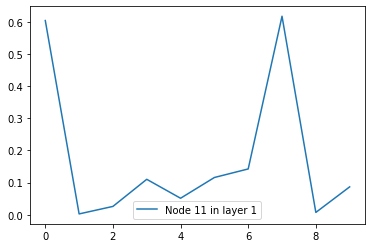


[0.49385223, 0.27387032, 0.13942349, 0.56616795, 0.18581557, 0.4660037, 0.08477666, 0.26711687, 0.18792957, 0.19992119]


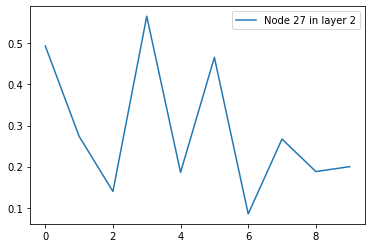

In [69]:
outputs = get_output_for_given_path(keys[0], X_sorted, class_sizes, range(10), NPF_effective_weights, NPF_effective_biases)

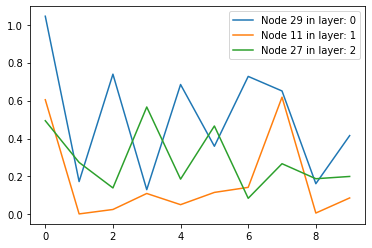

In [73]:
visualize_halfspace_intersections(outputs, range(10))

Visualizing output for individual datapoints

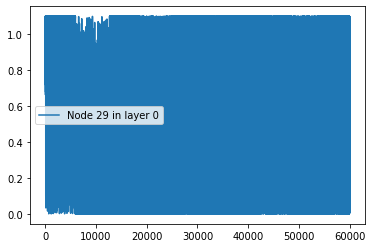

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


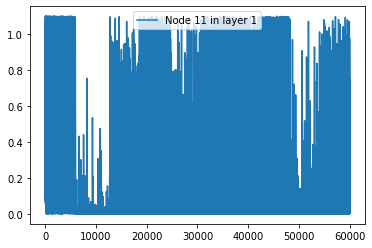

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


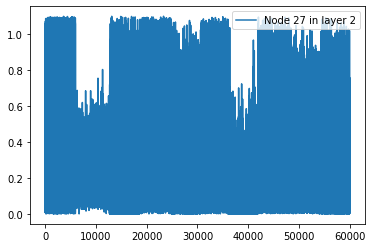

[(29, tensor([0.8105, 1.0691, 1.1000,  ..., 0.9942, 0.0304, 0.2268])),
 (11, tensor([0.3527, 0.0769, 0.1266,  ..., 0.0126, 0.0335, 0.0060])),
 (27, tensor([0.8672, 0.0326, 0.6853,  ..., 0.0105, 0.4349, 0.1308]))]

In [74]:
get_output_for_given_path(keys[0], X_sorted, class_sizes, range(X.shape[0]), NPF_effective_weights, NPF_effective_biases, False)

Visualizing using the raw data(without sorting by class)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


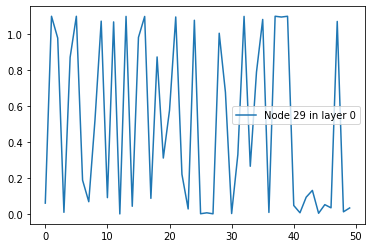

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


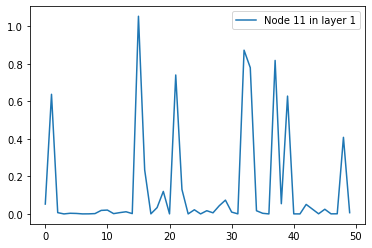

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


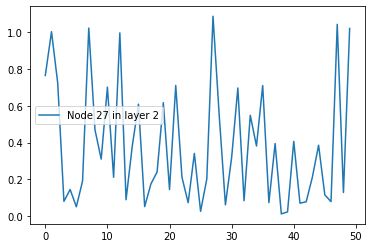

In [75]:
outputs = get_output_for_given_path(keys[0], X, class_sizes, range(50), NPF_effective_weights, NPF_effective_biases, False)

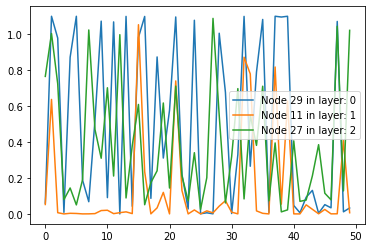

In [76]:
visualize_halfspace_intersections(outputs, range(50))